In [ ]:
from tensorflow.keras.models import model_from_json

# Load model architecture
with open('model_a10.json', 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)

# Load weights
model.load_weights('5model_weight.h5')

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = 'train/angry/Training_33331.jpg'
img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalizing the image

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def get_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Generate heatmap
heatmap = get_grad_cam(model, img_array, 'conv2d')

In [ ]:
import cv2

def overlay_heatmap(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite('grad_cam.jpg', superimposed_img)

overlay_heatmap(img_path, heatmap)

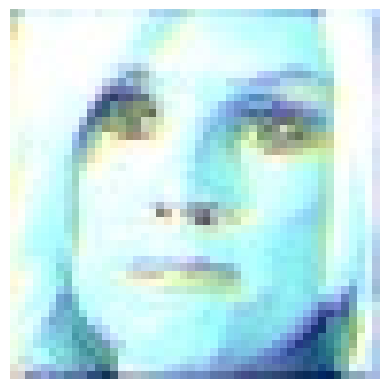

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Read the image
img2 = cv2.imread('grad_cam.jpg')

# Convert the image from BGR to RGB
img_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Plot the image
plt.imshow(img_rgb)
plt.axis('off')  # Hide the axis
plt.show()

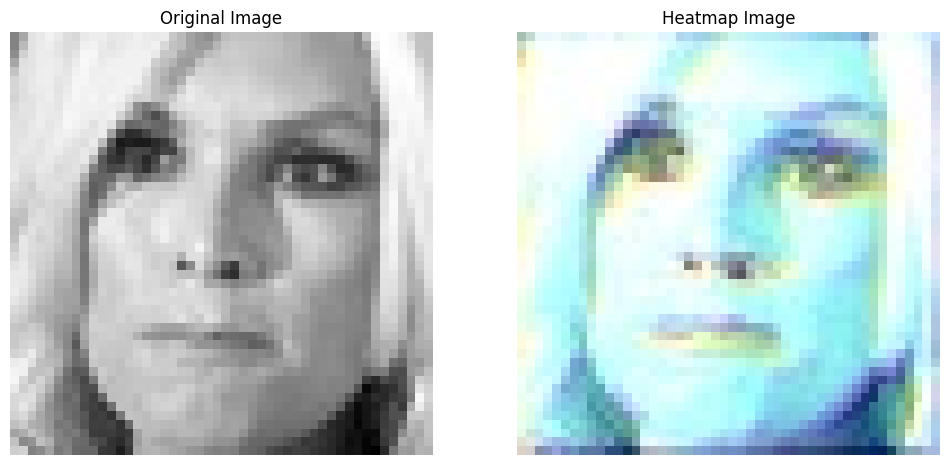

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

def plot_images(original_img_path, heatmap_img_path):
    # Load and preprocess the original image
    img = image.load_img(original_img_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Convert the image array back to a displayable format
    original_img = np.squeeze(img_array) * 255
    original_img = original_img.astype(np.uint8)

    # Read the heatmap image
    heatmap_img = cv2.imread(heatmap_img_path)
    heatmap_img_rgb = cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the original image
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')  # Hide the axis

    # Plot the heatmap image
    axes[1].imshow(heatmap_img_rgb)
    axes[1].set_title('Heatmap Image')
    axes[1].axis('off')  # Hide the axis

    # Display the plot
    plt.show()

# Paths to the images
original_img_path = 'train/angry/Training_33331.jpg'
heatmap_img_path = 'grad_cam.jpg'

# Plot the images
plot_images(original_img_path, heatmap_img_path)